# Keras: Recurrent Networks

In [ ]:
from sspipe import p, px
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as AUC

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_addons as tfa
import tensorflow_hub as hub
import tensorflow_text as text

## 1. Recurrent layers
[Recurrent Neural Network] (RNN) is a class of neural network architectures where nodes in a layers have internal connections, allowing to express temporal behaviour. There are many types of RNN layers, but they all share the same architecture. The image below shows the information flow for an observation, or for a document in the context of NLP.

:::{image} ../image/rnn_general.png
:height: 175px
:align: center
:::
<br>

Each green cell $\mathbf{x}_t\in\mathbb{R}^{V\times1}$ represents the embedding vector of a token, and each blue cell $\mathbf{h}_t\in\mathbb{R}^{D\times1}$ represents an output vector. With the input sequence size fixed at $T$, RNN adjusts itself to match the input length. The most important part of a RNN layer is the grey cell $A$ that repeats multiple times, being account for information processing. We can see that at a time step, the output value $\mathbf{h}_t$ is influenced by all previous steps $\mathbf{h}_{t-1},\mathbf{h}_{t-2},\dots$, besides the input $\mathbf{x}_t$. This design resembles *memory* and enables RNN to capture sequential relationship.

There are many architectures for a recurrent layers, the only difference between them is how the cell $A$ being desgined. In this article, we are going to learn the cell architectures of Simple RNN, LSTM and GRU.

[Recurrent Neural Network]: https://en.wikipedia.org/wiki/Recurrent_neural_network

### 1.1. Building blocks
This section introduces common blocks in recurrent architectures. Knowing each of them separately helps us understanding compicated designs better.

#### Concatenation

:::{image} ../image/rnn_concatenation.png
:height: 300px
:align: center
:::
<br>

Let's say we want to transform two input vectors $\mathbf{u}\in\mathbb{R}^{U\times1}$ and $\mathbf{v}\in\mathbb{R}^{V\times1}$ into $\mathbf{y}\in\mathbb{R}^{D\times1}$. Note that $U$ and $V$ are fixed dimensionalities of input, while $D$ is the desired output size. With weight matrices
$\mathbf{W}_{yu}\in\mathbb{R}^{D\times U},\mathbf{W}_{yv}\in\mathbb{R}^{D\times V}$
and bias vector $\mathbf{b}_y\in\mathbb{R}^{D\times1}$,
the actual formula behind the above image is:

$$\mathbf{y}=\mathbf{W}_{yu}\mathbf{u}+\mathbf{W}_{yv}\mathbf{v}+\mathbf{b}_y$$

Here, all three terms have size $(D\times1)$, same as $\mathbf{y}$. We can also view the above formula as concatenating $\mathbf{u}$ and $\mathbf{v}$ into a single input vector $\mathbf{x}\in\mathbb{R}^{(U+V)\times1}$, then scale it using a bigger weight matrix $\mathbf{W}_{yx}\in\mathbb{R}^{D\times(U+V)}$. This explains why the formula is visualized as a concatenation.

#### Gate

:::{image} ../image/rnn_gate.png
:height: 80px
:align: center
:::

A gate consists of two calculation steps, (1) passing a vector into sigmoid function and (2) using it as a percentage multiplier. The sigmoid function (denoted $\sigma$) is account for producing numbers in range $(0,1)$. We can see the purpose of gates very clearly here: they control how much information should be let through.

### 1.2. Simple RNN

#### Architecture
We call the vanilla architecture [Simple RNN] (1980s) to distinguish from the family name. Its cells is very simple, with only a concatenated value pass through an activation function. The activation function is usually $\tanh$ which produces values within the range $(-1,1)$, so that the network will be able to express *sentiment*. The cell architecture is described in the image and formula as follows:

:::{image} ../image/rnn_cell.png
:height: 160px
:align: center
:::
<br>

$$\mathbf{h}_t=\phi(\mathbf{W}_{hx}\mathbf{x}_t+\mathbf{W}_{hh}\mathbf{h}_{t-1}+\mathbf{b}_h)$$

A well-known issue with Simple RNN is that it only has *short-term memory*. This property is very easy to understand if you are familiar with the gradient vanishing problem of S-shaped activation functions. During [backpropagation through time] for a pair of words with large $\Delta t$, the product of partial derivatives may trigger saturation zones of $\tanh$, making the derivative of a word with respect to the other almost zero. As a result, Simple RNN fails to capture long-term memory.

[Simple RNN]: https://en.wikipedia.org/wiki/Recurrent_neural_network#Fully_recurrent
[backpropagation through time]: https://en.wikipedia.org/wiki/Backpropagation_through_time

#### Sizing
$\mathbf{W}_{hx},\mathbf{W}_{hh}$ and $\mathbf{b}_h$, as explained earlier, are the weight matrices and bias vector. Their corresponding sizes are $(D\times V)$, $(D\times D)$ and $(D\times 1)$. Note that these parameters are used across cells, hence taking sum of their sizes gets us the total number of parameters need to be trained:

$$D\times(D+V+1)$$

For example, we use a BERT pretrained model to encode a corpus containing $N=10\,000$ documents. The embedding dimension is $V=512$ and documents are truncated to have $T=128$ tokens. Then a RNN layer with $D=50$ will require $50\times(50+512+1)=28\,150$ parameters to process such input.

### 1.3. LSTM

#### Architecture
[LSTM] (Long Short-Term Memory) is a recurrent architecture published in 1997 that does not suffer from the gradient vanishing/exploding problem. This means, the network is able to capture long-term memory. The image below illustrates the architecture of a LSTM *memory cell*.

:::{image} ../image/lstm_cell.png
:height: 320px
:align: center
:::

The ability to manipulate information of LSTM is regulated via three gates (green node): forget $\mathbf{f}_t$, input $\mathbf{i}_t$ and output $\mathbf{o}_t$. Recall that a gate is a Sigmoid function ($\phi_1$ in this picture) followed by a multiplication. These gates give LSTM the ability to learn when to remember and when to forget, based on previous *hidden state* $\mathbf{h}_{t-1}$ and current input data $\mathbf{x}_t$. They all share the same formula, but with different parameters:

$$\begin{aligned}
\mathbf{f}_t &= \phi_1(\mathbf{W}_{fh}\mathbf{h}_{t-1}+\mathbf{W}_{fx}\mathbf{x}_t+\mathbf{b}_f) \\
\mathbf{i}_t &= \phi_1(\mathbf{W}_{ih}\mathbf{h}_{t-1}+\mathbf{W}_{ix}\mathbf{x}_t+\mathbf{b}_i) \\
\mathbf{o}_t &= \phi_1(\mathbf{W}_{oh}\mathbf{h}_{t-1}+\mathbf{W}_{ox}\mathbf{x}_t+\mathbf{b}_o) \\
\end{aligned}$$

The key component contributing to the long-term-memory ability of LSTM is the *internal state* $\mathbf{c}_t$. This variable works like a conveyor belt running straight through the entire chain, gathering *additional* information $\tilde{\mathbf{c}}_t$ at each memory cell it goes through. Because new information is really mathematically added, we are assured the gradients can pass many times without vanishing or exploding. 

$$\begin{aligned}
\tilde{\mathbf{c}}_t &= \phi_2(\mathbf{W}_{ch}\mathbf{h}_{t-1}+\mathbf{W}_{cx}\mathbf{x}_t+\mathbf{b}_c) \\
\mathbf{c}_t &= \mathbf{f}_t\odot\mathbf{c}_{t-1}+\mathbf{i}_t\odot\tilde{\mathbf{c}}_t \\
\end{aligned}$$

Finally, the current *hidden state* $\mathbf{h}_t$ is computed by $\tanh$-activating $\mathbf{c}_t$ and scaling it down by the output gate $\mathbf{o}_t$.

$$\begin{aligned}
\mathbf{h}_t &= \mathbf{o}_t\odot\phi_2(\mathbf{c}_t) \\
\end{aligned}$$

We can see LSTM has 4 concatenations between $\mathbf{x}$ and $\mathbf{h}$, so its number of parameters will be $4\times D\times(D+V+1)$.

[LSTM]: https://en.wikipedia.org/wiki/Long_short-term_memory

#### Steps

:::{image} ../image/lstm_steps.png
:height: 450px
:align: center
:::
<br>

Because it is quite hard to track what is going on by looking at the full architecture of LSTM, we will break it down into four steps:
- Step 1, construct the *forget gate* that decides how much old data should be kept.
- Step 2, construct the *input gate* that decides what new data should be stored.
- Step 3, compute the *internal state* by combining two processes, *forgetting* and *receiving* information.
- Step 4, construct the *output gate* and compute the output value.

### 1.4. GRU

#### Architecture
[Gated Recurrent Units] (GRU) was published in 2014 as an alternative that retains key idea of LSTM but is faster in computation.

[Gated Recurrent Units]: https://en.wikipedia.org/wiki/Gated_recurrent_unit

:::{image} ../image/gru_cell.png
:height: 320px
:align: center
:::

GRU comes with the two-gate mechanism, *reset* ($\mathbf{r}_t$) and *update* ($\mathbf{z}_t$), rather than three like LSTM. They are also based on previous *hidden state* $\mathbf{h}_{t-1}$ and current input data $\mathbf{x}_t$ like LSTM's gates.

$$\begin{aligned}
\mathbf{r}_t &= \phi_1(\mathbf{W}_{rh}\mathbf{h}_{t-1}+\mathbf{W}_{rx}\mathbf{x}_t+\mathbf{b}_r) \\
\mathbf{z}_t &= \phi_1(\mathbf{W}_{zh}\mathbf{h}_{t-1}+\mathbf{W}_{zx}\mathbf{x}_t+\mathbf{b}_z) \\
\end{aligned}$$

Next, the new information $\tilde{\mathbf{h}}_t$ is computed by two processes, *receiving* new information $\mathbf{x}_t$ and *forgetting* old information $\mathbf{h}_{t-1}$. Then, it is added to the old state weightedly (weights are controled via the update gate) to get the current hidden state $\mathbf{h}_t$. Unlike LSTM, GRU does not maintain the *internal state* but resembles its behaviour.

$$\begin{aligned}
\tilde{\mathbf{h}}_t &= \phi_2(\mathbf{W}_{hx}\mathbf{x}_t+\mathbf{W}_{hh}(\mathbf{r}_t\odot\mathbf{h}_{t-1})+\mathbf{b}_h) \\
\mathbf{h}_t &= \mathbf{z}_t\odot\mathbf{h}_{t-1}+(1-\mathbf{z}_t)\odot\tilde{\mathbf{h}}_{t-1} \\
\end{aligned}$$

The number of parameters of a GRU layer is $3\times D\times(D+V+1)$, as it has 3 concatenations of $\mathbf{x}$ and $\mathbf{h}$.

#### Steps

:::{image} ../image/gru_steps.png
:height: 450px
:align: center
:::


### 1.5. Bi-directional
All the recurrent layers have been introduced so far are uni-directional, i.e. going from the left to the right. In other words, our networks only model leftward context. This design works fine for time series data, but for text data, rightward context also matters. This problem is solved by generalizing recurrent layers to [bi-directional]. The architecture is described in the following image:

:::{image} ../image/rnn_bidirectional.png
:height: 245px
:align: center
:::
<br>

We can observe that a bi-directional layer is composed of a foward sub-layer and a backward sub-layer. They can be of the same type or not, and their cells are denoted $A$ and $A'$ respectively. Their corresponding outputs $\overrightarrow{\mathbf{h}}_t$ and $\overleftarrow{\mathbf{h}}_t$ are then merged into $\mathbf{h}_t$ using various strategies, where the most common one is concatenating.

[bi-directional]: https://en.wikipedia.org/wiki/Bidirectional_recurrent_neural_networks

### 1.6. Implementation
TensorFlow implements all three recurrent layers via [`SimpleRNN`], [`LSTM`] and [`GRU`]. Each has a cell-level counterpart that can be used with the abstract class [`RNN`]. There is also [`Bidirectional`] working as a wrapper around recurrent layers for bi-directional behaviour. They have the following hyperparameters:
- `units`: the dimensionality of output space ($D$).
- `activation`: the activation function for processing data ($\phi$ in Simple RNN and $\phi_2$ in LSTM, GRU), defaults to *tanh*.
- `recurrent_activation`: the activation function for gates ($\phi_1$, only available for LSTM and GRU), defaults to *sigmoid*.

[`SimpleRNN`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN
[`LSTM`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
[`GRU`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU
[`RNN`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/RNN
[`Bidirectional`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional

In [3]:
from sspipe import p, px
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score as AUC

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
import tensorflow_addons as tfa
# import tensorflow_hub as hub
# import tensorflow_text as text

In [2]:
dfSpam = pd.read_csv('../data/spam_message.csv')
xTrainRaw, xTestRaw, yTrain, yTest = train_test_split(dfSpam.content, dfSpam.spam, test_size=0.2)

In [3]:
def process_feature(corpus):
    bertProcessor = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
    bertEncoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/2')
    corpus = corpus.str.lower()
    corpus = bertProcessor(corpus)
    corpus = bertEncoder(corpus)
    corpus = corpus['sequence_output']
    return corpus
    
xTrain = process_feature(xTrainRaw)
xTest = process_feature(xTestRaw)

In [22]:
xTrain.shape

TensorShape([4457, 128, 256])

In [26]:
layers.SimpleRNN(16)(xTrain).shape

TensorShape([4457, 16])

In [27]:
layers.SimpleRNN(16, return_sequences=True)(xTrain).shape

TensorShape([4457, 128, 16])

:::{note}

When using RNN with other layers, there are two cases:
- The next layer being Fully Connected, then we only use the last hidden state, $\mathbf{h}_T$. The output shape in this case is  $(N\times D)$.
- The next layer being another RNN layer (including LSTM and GRU), then we need to return the full sequence $\mathbf{h}_1,\mathbf{h}_2,\dots,\mathbf{h}_T$. This is done by specifying `return_sequences=True`. The output shape this time is $(N\times T\times D)$.

:::

In [4]:
model = keras.Sequential([
    layers.SimpleRNN(10, return_sequences=True),
    layers.SimpleRNN(5),
    layers.Dense(1, activation='sigmoid')
])
model.compile(loss='mse', optimizer='adam')
model.fit(xTrain, yTrain)

140/140 [==============================] - 5s 25ms/step - loss: 0.0793


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128, 10)           2670      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 5)                 80        
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 2,756
Trainable params: 2,756
Non-trainable params: 0
_________________________________________________________________


In [7]:
yTestPred = model.predict(xTest)
AUC(yTest, yTestPred)

0.9789832918592251

In [9]:
_ = [print(weight.shape) for weight in model.layers[0].weights]

(256, 10)
(10, 10)
(10,)


In [24]:
x = tf.constant([
    [1,2,3,4,],
    [0,4,1,1,],
])
y = tf.constant([0.,1.])

In [30]:
model = keras.Sequential([
    layers.Embedding(input_dim=10, output_dim=20),
    layers.Dense(1),
])
model.compile(loss='mse')
model.fit(x, y)

1/1 [==============================] - 0s 221ms/step - loss: 0.5121


In [31]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 20)          200       
                                                                 
 dense_1 (Dense)             (None, None, 1)           21        
                                                                 
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________


## 2. Recurrent architectures

### 2.1. Seq2Seq
[Seq2Seq], introduced in the paper [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/abs/1409.3215) (2014), is a Deep Learning architecture desgined mainly for [neural machine translation] and [question answering]. It aims to transform an input sequence to a new one, both can be of arbitrary lengths. Its design is very natural to translation problems, and has resolved the fixed-length constraint in standalone recurrent layers.

[Seq2Seq]: https://en.wikipedia.org/wiki/Seq2seq
[neural machine translation]: https://en.wikipedia.org/wiki/Neural_machine_translation
[question answering]: https://en.wikipedia.org/wiki/Question_answering

#### Architecture
The Seq2Seq uses an encoder-decoder architecture, in which each process uses a recurrent layer(s) such as LSTM and GRU. With $(\mathbf{x}_1,\dots,\mathbf{x}_S)$ a source sentence and $(\mathbf{y}_1,\dots,\mathbf{y}_T)$ the target sentence, the architecture of Seq2Seq is described in the following image:

:::{image} ../image/seq2seq.png
:height: 300px
:align: center
:::
<br>

The *encoder* is simply a recurrent layer where the hidden state at a time step is expressed by $(\mathbf{x}_s,\mathbf{e}_{s-1})\mapsto\mathbf{e}_s$. The last hidden state will be used as the output, known under the name *context vector* $\mathbf{c}=\mathbf{e}_S$ (sometimes called *sentence embedding* or *thought vector*).

The *decoder* is a bit different, in which the hidden state has the signature $(\mathbf{y}_{t-1},\mathbf{d}_{t-1})\mapsto\mathbf{d}_t$. Note that each hidden state $\mathbf{d}_t$ must be computed using previous target token $\mathbf{y}_{t-1}$ to prevent target leakage. We also include $\mathbf{c}$ as the initialization state.

Because our goal is to take string input to predict string output, pre-trained embedding will not be used, at least for target text. Therefore, an embedding layer is used to process data in both encoder and decoder. This layer turns each word into a vector, just like Word2Vec or BERT do, but all embedding values are treated learnable parameters by our network.

### 2.2. Attention
A weakness of Seq2Seq can be easily observed, is the bottleneck at the context vector $\mathbf{c}$, which prevents the network from remembering long sequences, especially the first part. This problem is resolved by applying an [Attention mechanism] to compute a distinct context vector for each target token, proposed by Bahdanau in 2014. Note that the idea of Attention mechanism has been around for a while and has been applied in different areas, but this is the first time applied in the NLP field.

[Attention mechanism]: https://en.wikipedia.org/wiki/Attention_(machine_learning)
[`Attention`]: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Attention

#### Attention mechanism
In 2017, the paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762)
generalizes Attention mechanism using the concept of *query*, *key* and *values*, denoted respectively by the vectors $\mathbf{q}$, $\mathbf{k}$ and $\mathbf{v}$.

Let's talk about *key* and *value* first, as they share the same meaning as in Python dictionaries, so they should be familiar to Data Scientists. Intuitively, think about a *key* as consumer behaviour and demographic data, and *value* as consumer income. Each pair of key-value forms an observation, then the database can be denoted $\mathcal{D}=\{(\mathbf{k}_1,\mathbf{v}_1),\ldots,(\mathbf{k}_N,\mathbf{v}_N)\}$. For a new user whose feature space denoted by $\mathbf{q}$, we perform a *query over the database* to calculate the *attention score*:

$$\alpha_n=\text{softmax }\alpha(\mathbf{q},\mathbf{k}_n)$$

Here, $\alpha$ is the *alignment function* which measures the similarity between two vectors, in which the most simple form is just the dot product. This function outputs $\alpha_n$, implies how similar the query is to each key. In practice, we would want $\alpha_1,\ldots,\alpha_N$ to (1) be positive and (2) add up to $1$, so that they resemble normalized weights. This is addressed nicely by applying a softmax function, explaining its existence in the formula. Now, the output for $\mathbf{q}$ can be easily computed as the weighted sum of all values in the database:

$$\mathbf{o}=\sum_{n=1}^{N}{\alpha_n\mathbf{v}_n}$$

:::{image} ../image/attention_mechanism.png
:height: 300px
:align: center
:::

#### Bahdanau-style
In the paper
[Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/abs/1409.0473)
(2014), Bahdanau introduces Additive Attention being an extension to the Seq2Seq network. The architecture of this network leaves the encoder in Seq2Seq untouched (which produces hidden states $\mathbf{e}_1,\dots,\mathbf{e}_S$), and modifies only the decoder. Let's say we are at decoder step $t$, the Attention mechanism is applied as follows:

- The encoder hidden states are used as both keys and the corresponding values: $\mathbf{k}_s=\mathbf{v}_s=\mathbf{e}_s$
- The *previous* decoder hidden state is used as the query: $\mathbf{q}=\mathbf{d}_{t-1}$
- The output of Attention mechanism is the context vector for the current step: $\mathbf{o}=\mathbf{c}_t$
- The alignment function is designed to be *learnable* by concatenating the query and the key, then passing to two bias-free Fully Connected layers. The first layer with the weight $\mathbf{W}^{(1)}$ brings $\mathbf{q}$ and $\mathbf{k}$ to the same dimension. The second layer with the weight $\mathbf{W}^{(2)}$, in fact, is just a vector that accounts for producing a scalar.

$$\alpha(\mathbf{q},\mathbf{k}_s)=\text{tanh}([\mathbf{q},\mathbf{k}_s]\mathbf{W}^{(1)})\mathbf{W}^{(2)} $$

After producing $\mathbf{c}_t$, this vector is concatenated to $\mathbf{y}_{t-1}$ and the signature of the decode is turned into $([\mathbf{y}_{t-1};\mathbf{c}_t],\mathbf{d}_{t-1})\mapsto\mathbf{d}_t$. This process is repeated for $t=1,2,\ldots,T$, in which the intialization is $\mathbf{d}_0=\mathbf{e}_S$. The below image illustrates how to use Attention to predict the second word ($t=2$).

:::{image} ../image/attention_bahdanau.png
:height: 380px
:align: center
:::

#### Luong-style
In 2015, Thang Luong proposed another Attention style via the paper
[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025). It is also meant for improving Seq2Seq, with two differences.

First, there is a modification in the order of steps. With an intermediate variable $\tilde{\mathbf{d}}_t$ used as query, Luong-style Attention is easier to implement and thus allows different alignment functions to be pluged in. The image below shows the prediction process for the same word as Bahdanau example.

:::{image} ../image/attention_luong.png
:height: 380px
:align: center
:::

The second difference in this paper, is the introduction of three new alignment functions:
- *dot* (which is simply the dot product): $\alpha(\mathbf{q},\mathbf{k}_s)=\mathbf{q}^\text{T}\mathbf{k}_s$
- *general* (which extends the dot product to be learnable): $\alpha(\mathbf{q},\mathbf{k}_s)=\mathbf{q}^\text{T}\mathbf{W}\mathbf{k}_s$
- *location* (which is computed solely on the decoder hidden state): $\alpha(\mathbf{q},\mathbf{k}_s)=\mathbf{W}\mathbf{q}$

#### Intuition
Attention is not only powerful, but also interpretable.

Imagine we are translating documents from English to Vietnamese. With the Seq2Seq model, we read the full sentence at once, remember it (context vector) and then translate. Because the context vector is too small to summarize the sentence, there will be a high chance that we *forget* some details from the English document. A better way is to write down *keywords* during reading, which will be very helpful for translation later. This is exactly what Attention trying to model: how each Vietnamese word *attends* to different parts of the English sentence.

So can we ask the Attention model to *share* those *keywords* with us after learning? The answer is yes, they are the set of attention weights $\alpha_{t,s}$. They can be interpreted as a $S\times T$ attention matrix.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn', 'seaborn-whitegrid'])
%config InlineBackend.figure_format = 'retina'

In [10]:
data = [
    [1.0, 0.0, 0.0, 0.0],
    [0.0, 0.8, 0.2, 0.0],
    [0.0, 0.2, 0.1, 0.7]
]

index = ['Tôi', 'đi', 'học']
columns = ['I', 'go', 'to', 'school']

df = pd.DataFrame(data=data, index=index, columns=columns)

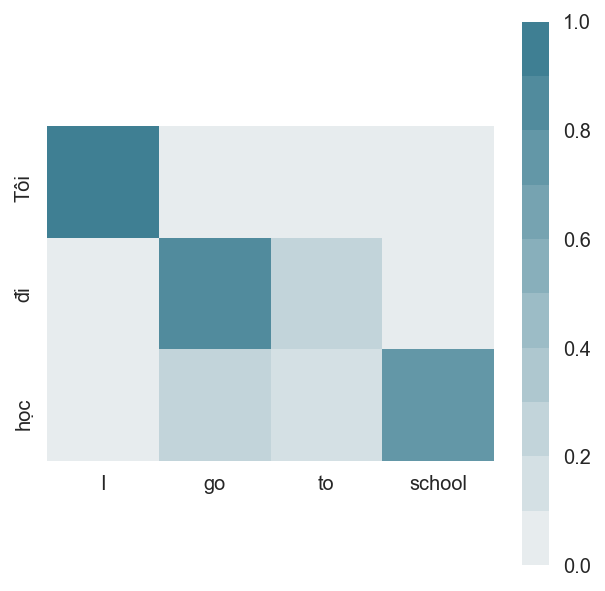

In [11]:
palette = sns.diverging_palette(20, 220, n=20)[10:]

plt.figure(figsize=(5,5))
sns.heatmap(
    df, square=True,
    cmap=palette,
    vmin=0, vmax=1,
)
plt.show()

### 2.2. Transformer
The final boss is here: [Transformer], published in the paper
[Attention Is All You Need](https://arxiv.org/abs/1706.03762) (2017).
It goes a step futher in applying Attention, which outperforms RNNs and become state-of-the-art for a long time.

[Transformer]: https://en.wikipedia.org/wiki/Transformer_(machine_learning_model)

#### Self-attention

#### Scaled dot product

#### Positional encoding

## Resources
- *bioinf.jku - [Long Short-Term Memory](https://www.bioinf.jku.at/publications/older/2604.pdf)*
- *arxiv - [On the Properties of Neural Machine Translation: Encoder–Decoder Approaches](https://arxiv.org/pdf/1409.1259.pdf)*
- *amitness - [Recurrent Keras layer](https://amitness.com/2020/04/recurrent-layers-keras/)*
- *colah.github - [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)*
- *d2l - [Recurrent Neural Networks](https://d2l.ai/chapter_recurrent-neural-networks/index.html)*
- *d2l - [Modern Recurrent Neural Networks](https://d2l.ai/chapter_recurrent-modern/index.html)*
- *d2l - [Attention Mechanisms and Transformers](https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html)*
- *distill - [Memorization in RNNs](https://distill.pub/2019/memorization-in-rnns/)*
- *distill - [Augumented RNNs](https://distill.pub/2016/augmented-rnns/)*
- *lilianweng.github - [Attention? Attention!](https://lilianweng.github.io/posts/2018-06-24-attention/)*
- *blog.floydhub - [Attention mechanism](https://blog.floydhub.com/attention-mechanism/amp/)*
- *sebastianraschka - [Understanding and Coding the Self-Attention Mechanism of Large Language Models From Scratch](https://sebastianraschka.com/blog/2023/self-attention-from-scratch.html)*
- *slds-lmu.github - [Attention and Self-Attention for NLP](https://slds-lmu.github.io/seminar_nlp_ss20/attention-and-self-attention-for-nlp.html)*
- *e2eml - [Transformers from Scratch](https://e2eml.school/transformers.html)*
---
- https://towardsdatascience.com/day-1-2-attention-seq2seq-models-65df3f49e263
- https://towardsdatascience.com/seq2seq-model-in-tensorflow-ec0c557e560f
- https://storrs.io/attention/amp/
- https://erdem.pl/2021/05/introduction-to-attention-mechanism
- https://vaclavkosar.com/ml/transformers-self-attention-mechanism-simplified
- https://www.baeldung.com/cs/attention-mechanism-transformers
- https://theaisummer.com/attention/
- https://towardsdatascience.com/intuitive-understanding-of-attention-mechanism-in-deep-learning-6c9482aecf4f
- https://towardsdatascience.com/word-level-english-to-marathi-neural-machine-translation-using-seq2seq-encoder-decoder-lstm-model-1a913f2dc4a7
- https://ai.googleblog.com/2017/08/transformer-novel-neural-network.html

## Install

In [2]:
!python3 -m pip --version

pip 22.3.1 from /opt/anaconda3/lib/python3.8/site-packages/pip (python 3.8)


In [ ]:
pip install tensorflow --upgrade

In [ ]:
pip install tensorflow-addons